In [71]:
%matplotlib notebook
import matplotlib.pyplot as plt
import glob
import numpy as np
import pyuvdata
from matplotlib.colors import SymLogNorm
from astropy.time import Time
from astropy import units as u
from astropy.coordinates import get_sun
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
from astroplan import Observer

In [72]:
class obsinfo():
    
    def __init__(self, obsid):
        
        mwa = EarthLocation(lat=-26.70331940*u.deg, lon=116.67081524*u.deg)
        mwa_obs = Observer(longitude=mwa.lon, latitude=mwa.lat, elevation=0*u.m,
                           name="MWA", timezone="Australia/Perth")
        self.obsid = obsid
        self.t = Time(obsid, format='gps')
        self.lst = mwa_obs.local_sidereal_time(self.t).hour
        self.sun_loc = get_sun(self.t)
        self.sun_ra = self.sun_loc.ra.hour
        self.sun_dec = self.sun_loc.dec.hour

        frame = AltAz(obstime=self.t, location=mwa)
        self.sunaltaz = get_sun(self.t).transform_to(frame)
        self.sun_alt = self.sunaltaz.alt.deg
        self.sun_az = self.sunaltaz.az.deg
        
    def printinfo(self):
        print('Obsid = ', str(self.obsid))
        print('Datetime = ', self.t.datetime)
        print('LST = ', self.lst)
        print('Sun alt = ', self.sun_alt)

In [80]:
# Choose obs, get some info
obsid = 1220461368
info = obsinfo(obsid)
info.printinfo()
print(info.sun_loc)

('Obsid = ', '1220461368')
('Datetime = ', datetime.datetime(2018, 9, 8, 17, 3, 7))
('LST = ', 0.00023321329390668666)
('Sun alt = ', -65.51029767832209)
<SkyCoord (GCRS: obstime=1220461368.0, obsgeoloc=(0., 0., 0.) m, obsgeovel=(0., 0., 0.) m / s): (ra, dec, distance) in (deg, deg, AU)
    (166.87046703, 5.62417725, 1.00745547)>


In [67]:
info.sun_loc.ra.hms

hms_tuple(h=16.0, m=31.0, s=27.1606395630252)

In [112]:
# Read in files
files = sorted(glob.glob('/data5/mmodes/raw_data/run0/' + str(obsid) + '*.uvfits'))
uvs = []

for f in files:
    uv = pyuvdata.UVData()
    uv.read(f)
    uvs.append(uv)

<IPython.core.display.Javascript object>


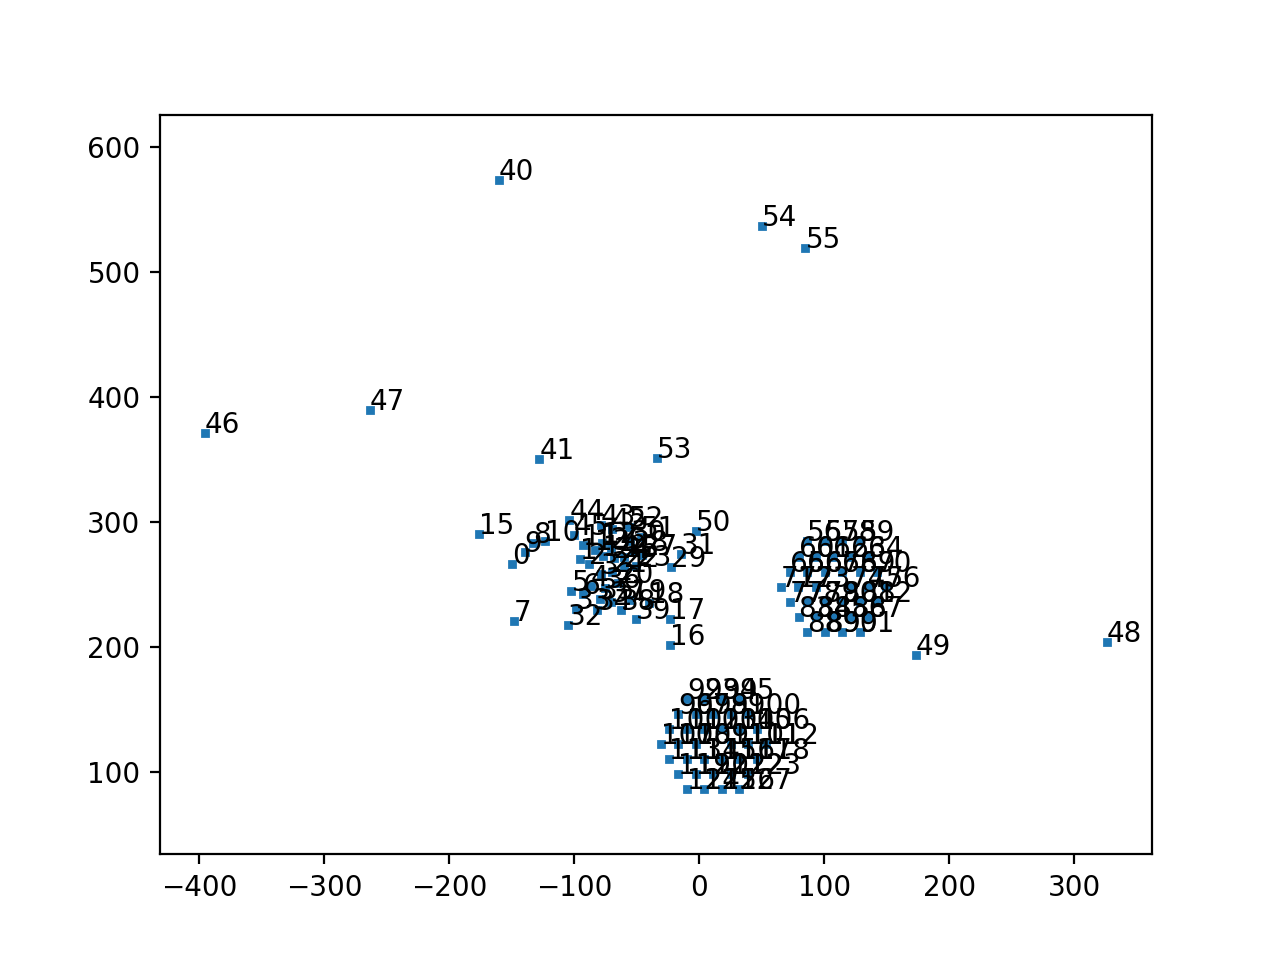

In [82]:
# Plot antenna positions
plt.figure()
uv = uvs[0]
antpos, ants = uv.get_ENU_antpos(uv.antenna_positions)
plt.plot(antpos[:, 0], antpos[:, 1], 's', ms=2)
plt.axes().set_aspect('equal', 'datalim')

for label, x, y in zip(ants, antpos[:, 0], antpos[:, 1]):
    plt.annotate(label, xy=(x, y))

<IPython.core.display.Javascript object>


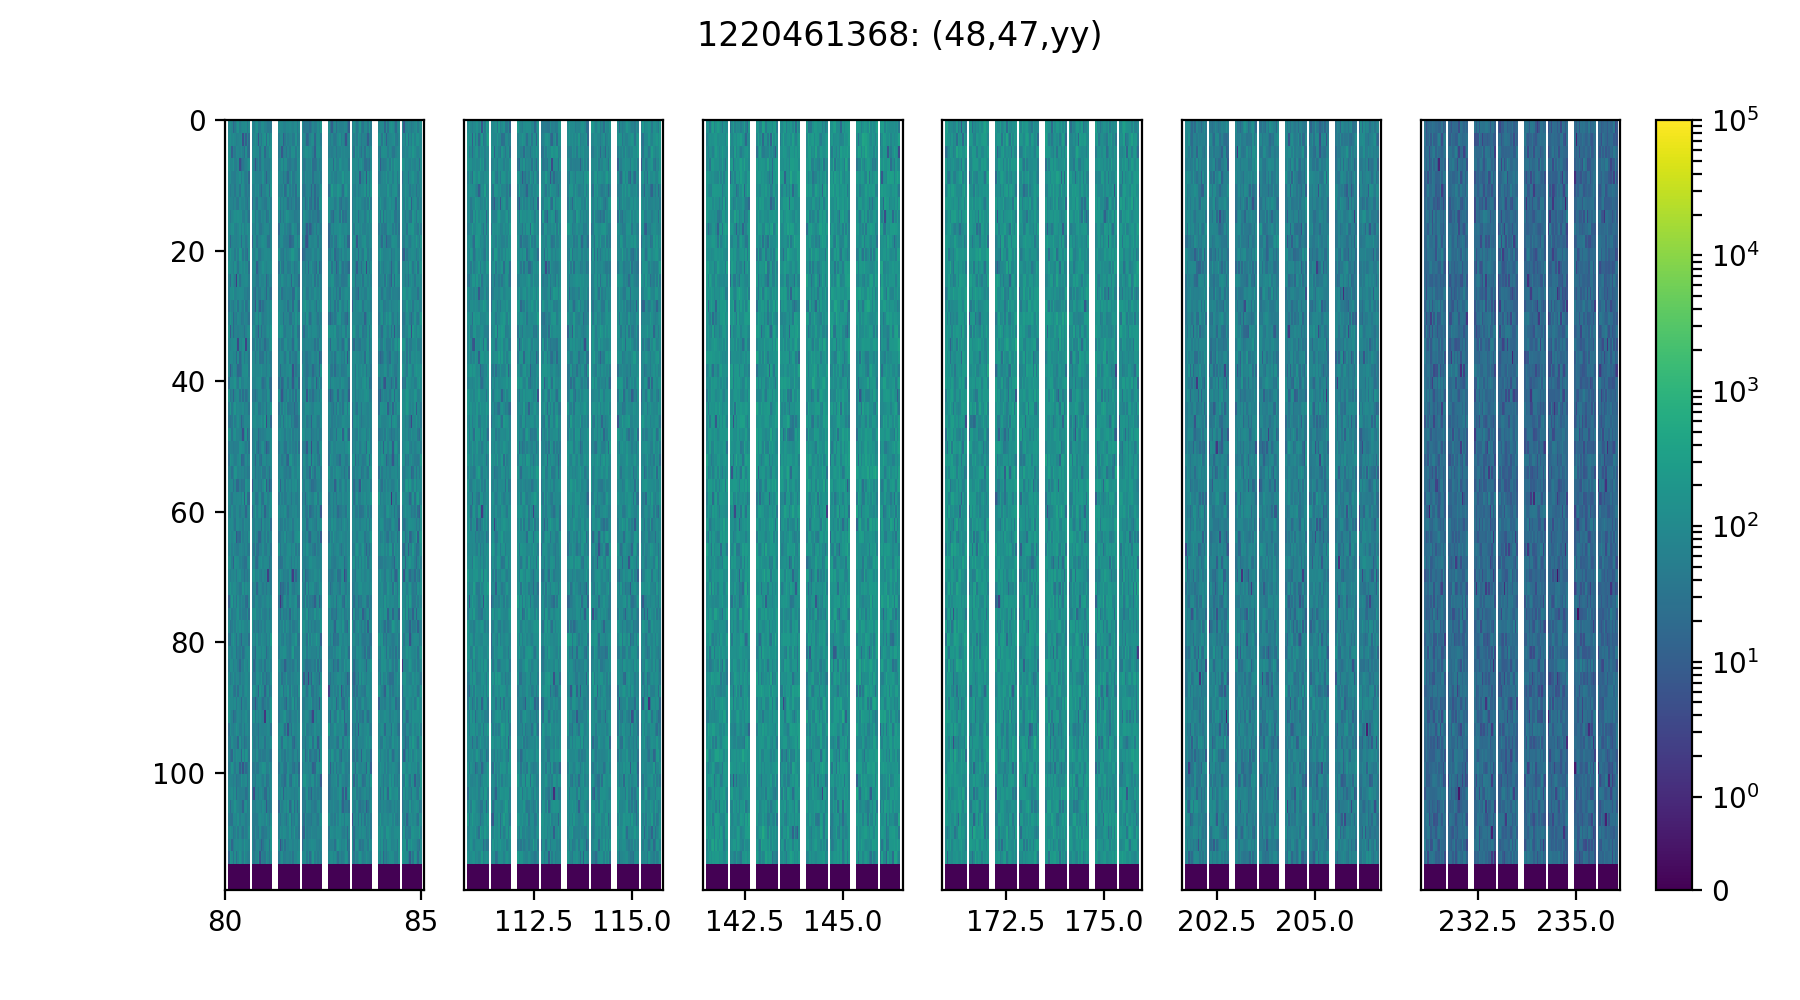

Text(0.5,0.98,'1220461368: (48,47,yy)')

In [113]:
# Look at some chosen baseline
ant1 = 48
ant2 = 47
pol = 'yy'
fig = plt.figure(figsize=(9, 5))
for i in range(len(files)):
    plt.subplot(1, len(files), i + 1)
    tmax = (uvs[i].time_array.max() - uvs[i].time_array.min()) * 24. * 60 * 60
    extent = [uvs[i].freq_array.min() * 1e-6, uvs[i].freq_array.max() * 1e-6,
              tmax, 0]
    d = np.ma.masked_array(np.abs(uvs[i].get_data((ant1, ant2, pol))), uvs[i].get_flags((ant1, ant2, pol)))
    im = plt.imshow(d, aspect='auto', extent=extent,
                    norm=SymLogNorm(linthresh=1e0, vmin=0, vmax=1e5))
#     im = plt.imshow(np.angle(uvs[i].get_data((ant1, ant2, pol))), aspect='auto', extent=extent,
#                     vmin=-np.pi, vmax=np.pi)
    if i > 0:
        plt.gca().set_yticks([])

fig.subplots_adjust(right=0.9)
cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])
fig.colorbar(im, cax=cbar_ax)
fig.suptitle(str(obsid) + ': (' + str(ant1) + ',' + str(ant2) + ',' + pol + ')')

In [43]:
uv.get_data(bl).shape

(60, 128, 4)

In [23]:
for i in range(len(uvs)):
    uvs[i].unphase_to_drift()
    uvs[i].set_uvws_from_antenna_positions()

In [44]:
d = []
d_high = []
bll = []
uvws = []
phases = []
tind = 30
f_ind = 100
p_ind = 0
for bl in uv.get_baseline_nums():
    temp = [uv.get_data(bl) for uv in uvs]
    d.append(np.sum([np.median(np.abs(t)) for t in temp]))
    d_high.append(np.median(np.abs(temp[-1])))
    ind = np.where(uv.baseline_array == bl)[0][0]
    
    bll.append(np.sqrt(np.sum(uv.uvw_array[ind]**2)))
    uvws.append(uv.uvw_array[ind])
    phases.append(np.angle(temp[-1][tind, f_ind, p_ind]))
uvws = np.array(uvws)

<IPython.core.display.Javascript object>


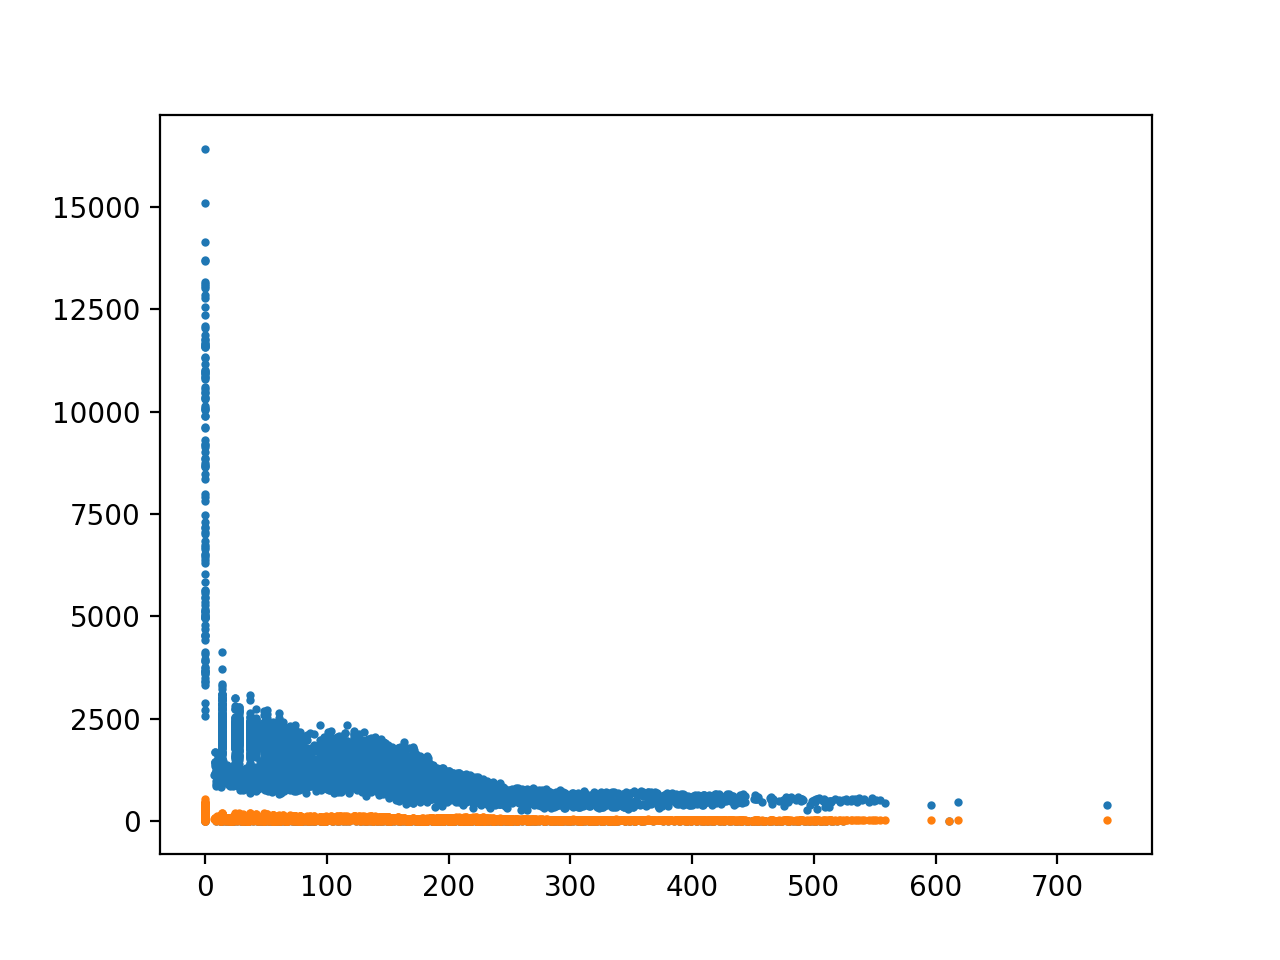

<IPython.core.display.Javascript object>


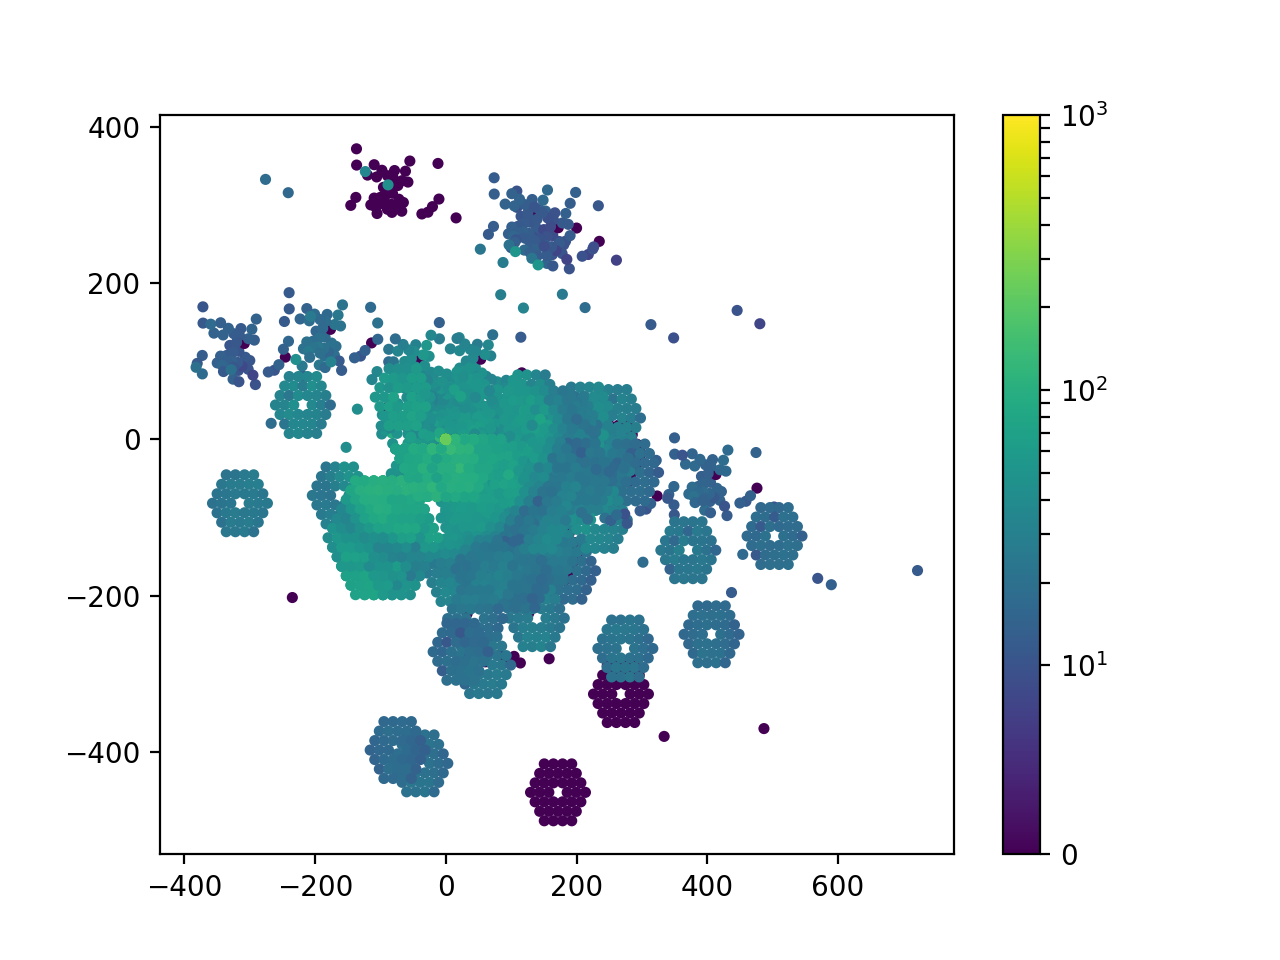

<IPython.core.display.Javascript object>


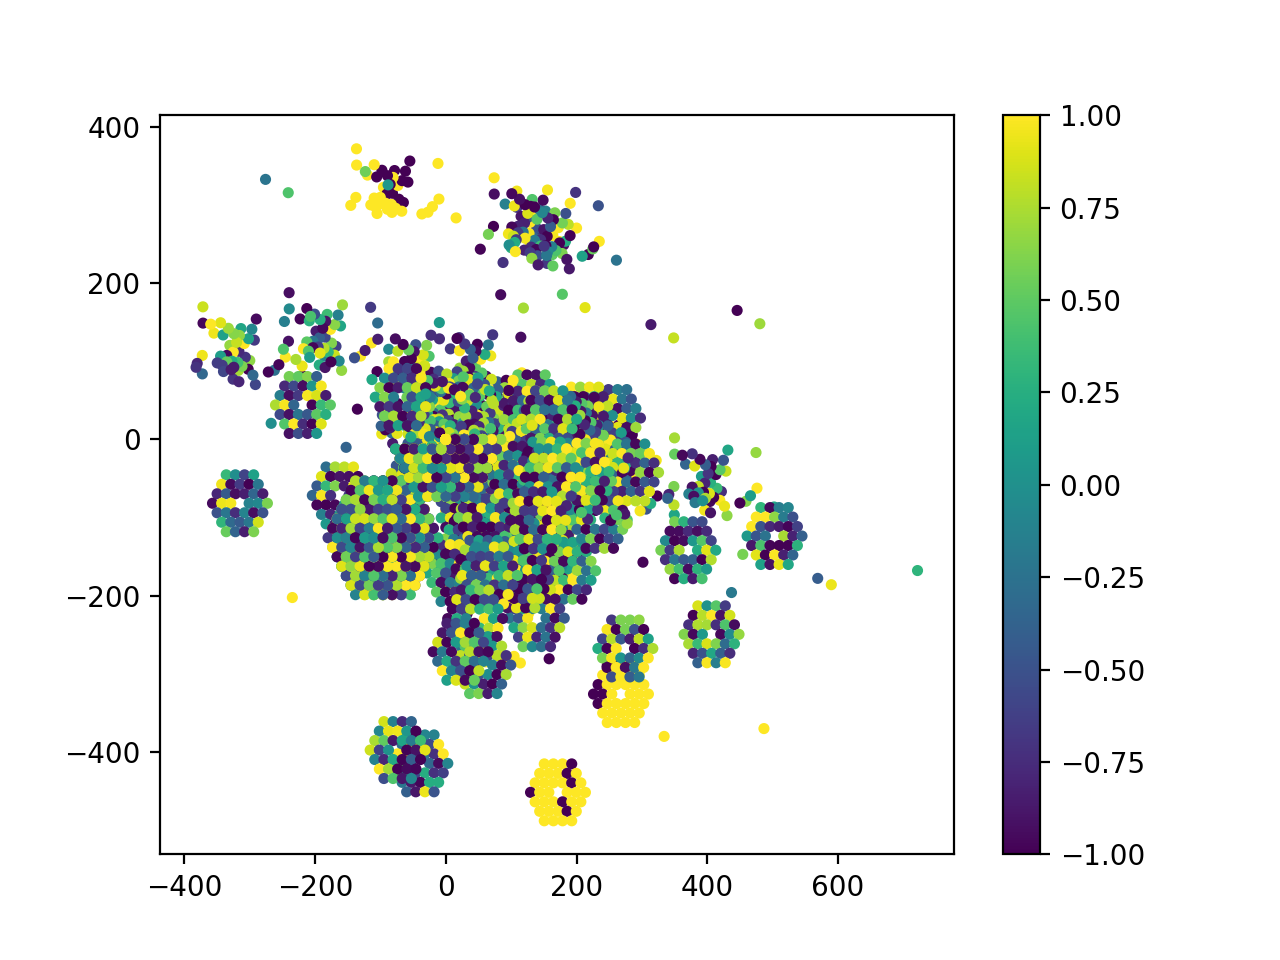

In [47]:
plt.figure()
uvws = np.array(uvws)
plt.plot(bll, d, 'o', ms=2)
plt.plot(bll, d_high, 'o', ms=2)
plt.figure()
plt.scatter(uvws[:, 0], uvws[:, 1], c=d_high, norm=SymLogNorm(linthresh=1e1, vmin=0, vmax=1e3),
            marker='.')
plt.colorbar()
plt.figure()
plt.scatter(uvws[:, 0], uvws[:, 1], c=np.cos(phases), vmin=-1, vmax=1, marker='.')
plt.colorbar()

In [27]:
np.rad2deg(2./171.)

0.6701260761764014

In [93]:
t = time.Time(uvs[0].time_array.mean(), format='jd')

In [53]:
uvs[-1].flag_array.mean()

0.9999979812661499

# Look at autos for any flagrantly bad antennas

## XX

<IPython.core.display.Javascript object>


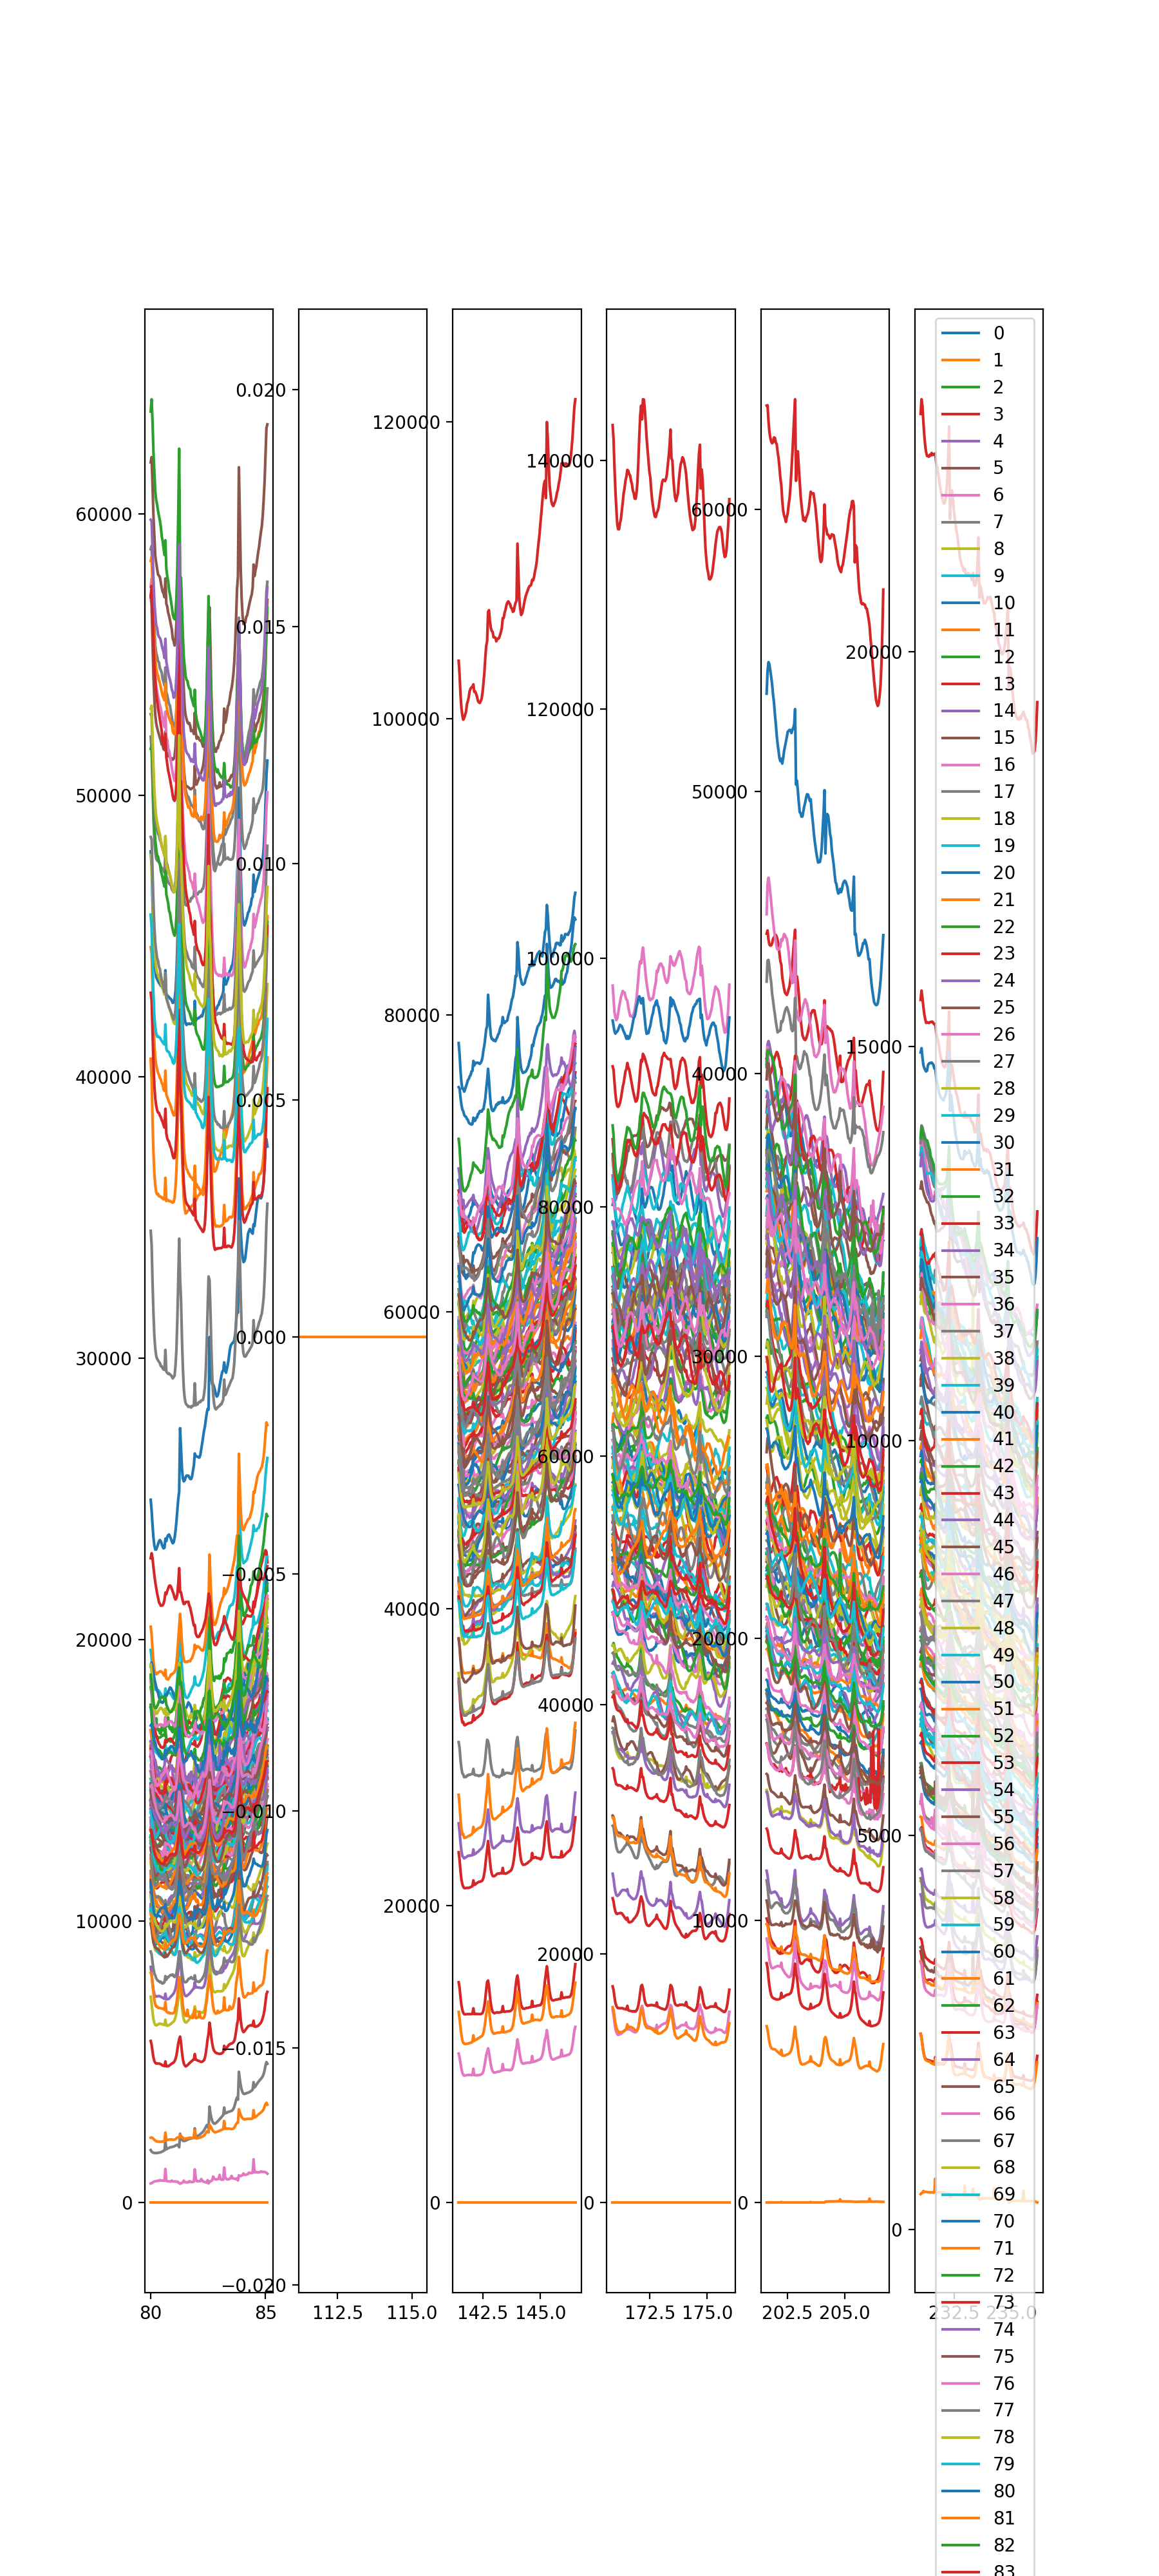

In [105]:
# Look at some chosen baseline
pol = 'xx'
fig = plt.figure(figsize=(9, 20))

for i in range(len(files)):
    plt.subplot(1, len(files), i + 1)
    for ant in uvs[i].antenna_numbers:
        d = np.median(np.abs(uvs[i].get_data((ant, ant, pol))), axis=0)
        plt.plot(uvs[i].freq_array[0, :] * 1e-6, d, label=str(ant))
        
plt.legend()
    
    
#     tmax = (uvs[i].time_array.max() - uvs[i].time_array.min()) * 24. * 60 * 60
#     extent = [uvs[i].freq_array.min() * 1e-6, uvs[i].freq_array.max() * 1e-6,
#               tmax, 0]
#     im = plt.imshow(np.abs(uvs[i].get_data((ant1, ant2, pol))), aspect='auto', extent=extent,
#                     norm=SymLogNorm(linthresh=1e0, vmin=0, vmax=1e5))
# #     im = plt.imshow(np.angle(uvs[i].get_data((ant1, ant2, pol))), aspect='auto', extent=extent,
# #                     vmin=-np.pi, vmax=np.pi)
#     if i > 0:
#         plt.gca().set_yticks([])

# fig.subplots_adjust(right=0.9)
# cbar_ax = fig.add_axes([0.92, 0.11, 0.02, 0.77])
# fig.colorbar(im, cax=cbar_ax)
# fig.suptitle(str(obsid) + ': (' + str(ant1) + ',' + str(ant2) + ',' + pol + ')')

<IPython.core.display.Javascript object>


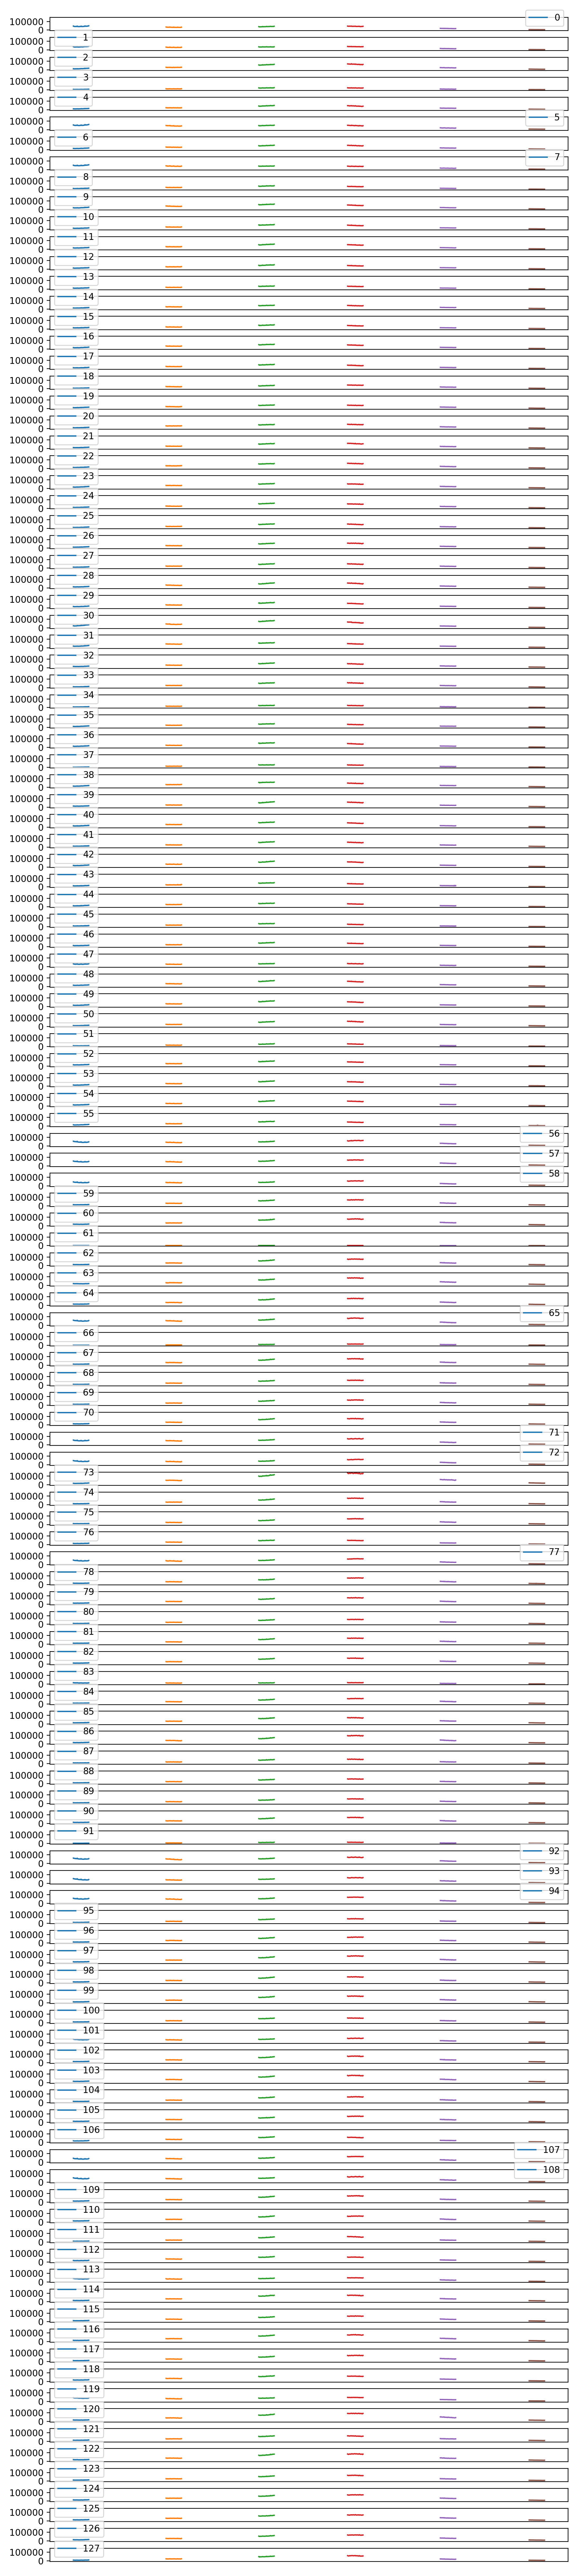

In [95]:
# Look at some chosen baseline
pol = 'xx'
fig = plt.figure(figsize=(9, 40))

for ai, ant in enumerate(uvs[0].antenna_numbers):
    if ai == 0:
        ax = plt.subplot(len(uvs[0].antenna_numbers), 1, ai + 1)
    else:
        plt.subplot(len(uvs[0].antenna_numbers), 1, ai + 1, sharex=ax, sharey=ax)
    for i in range(len(files)):
        d = np.mean(np.abs(uvs[i].get_data((ant, ant, pol))), axis=0)
        if i == 0:
            plt.plot(uvs[i].freq_array[0, :] * 1e-6, d, label=str(ant))
        else:
            plt.plot(uvs[i].freq_array[0, :] * 1e-6, d)
        if i != (len(files) - 1):
            plt.gca().set_xticks([])
    plt.legend()

plt.tight_layout()

<IPython.core.display.Javascript object>


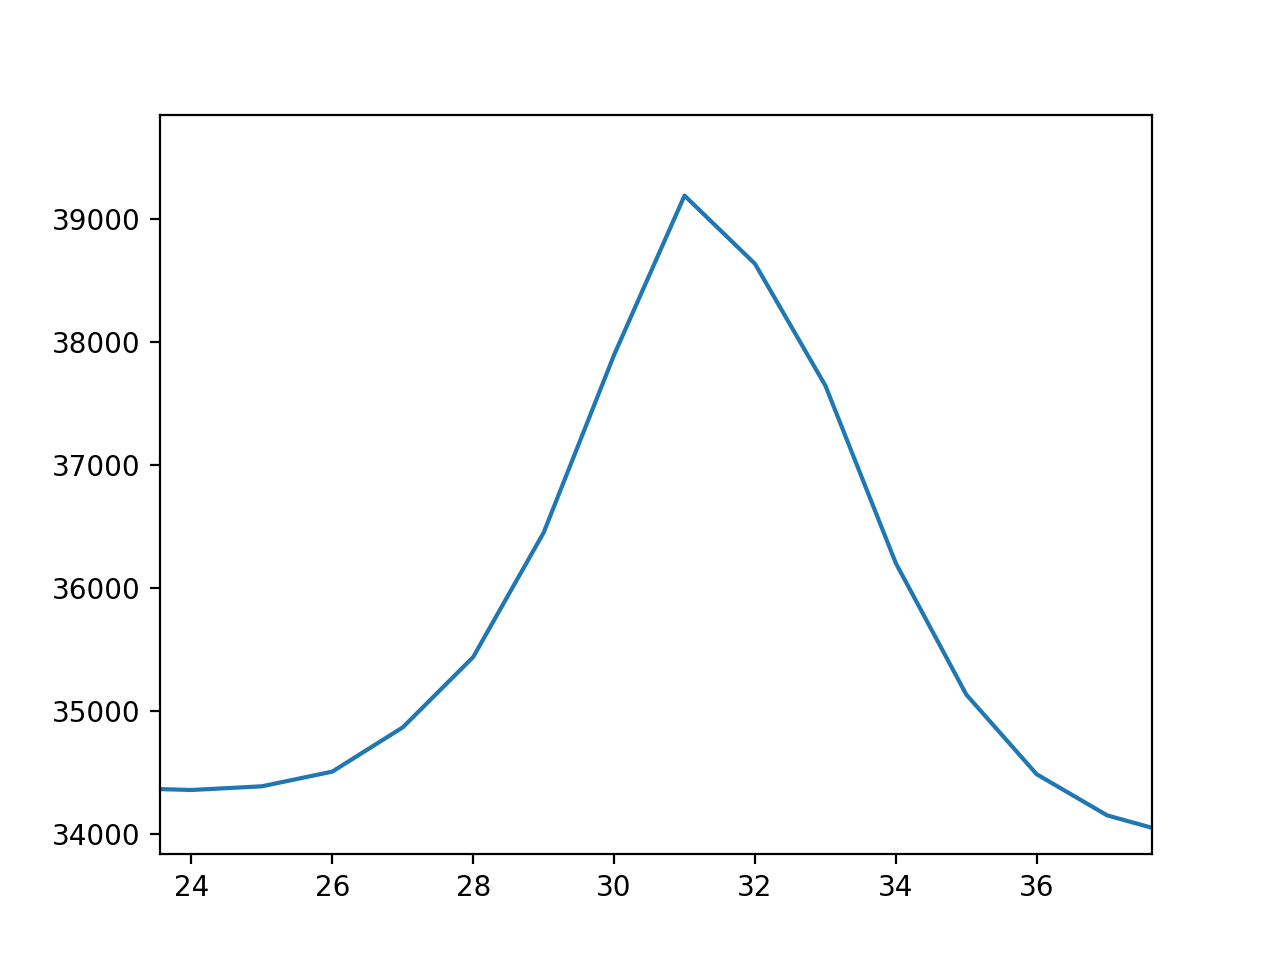

In [96]:
plt.figure()
d = np.mean(np.abs(uvs[0].get_data((1, 1, 'xx'))), axis=0)
# plt.plot(uvs[0].freq_array[0, :] * 1e-6, d)
plt.plot(d)

In [100]:
np.int(np.round((uvs[0].freq_array.max() - uvs[0].freq_array.min()) * 1e-6 / 1.28))

4

In [101]:
uvs[0].freq_array.size

128

In [103]:
for i in range(2):
    print(i)

0
1


In [104]:
for i in range(2):
    print(np.arange(i, 128, 32))
    print(np.arange(32 - i - 1, 128, 32))

[ 0 32 64 96]
[ 31  63  95 127]
[ 1 33 65 97]
[ 30  62  94 126]


In [108]:
uvs[0].flag_array.mean()

0.988649164244186